In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
import sklearn
import time
%matplotlib inline

## Data loading

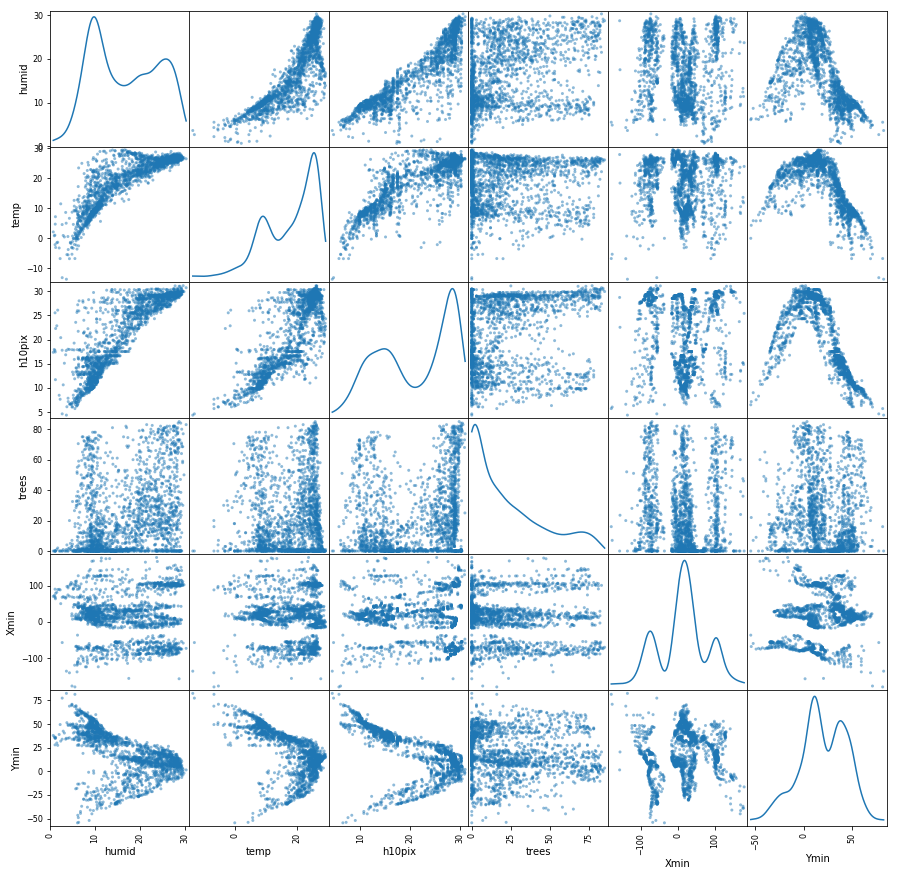

In [2]:
data_dengue = pd.read_csv("dengue.csv").dropna()
feature_keys_dengue = ['humid', 'temp' , 'h10pix', 'trees' , 'Xmin', 'Ymin']
X_dengue_df = data_dengue[feature_keys_dengue]
X_dengue = X_dengue_df.values
scaler = StandardScaler()
scaler.fit(X_dengue)
X_dengue_scld = scaler.transform(X_dengue)
X_dengue_scld = pd.DataFrame(data = X_dengue_scld, columns = X_dengue_df.columns)
_ = pd.plotting.scatter_matrix(X_dengue_df, diagonal = "kde", figsize = (15, 15))

## 23 a)

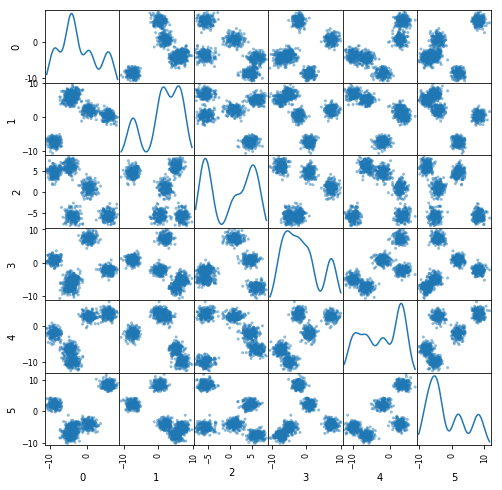

In [3]:
# dummy data
n_feat_dummy = 6
X_dummy, _ = make_blobs(1024, n_features = n_feat_dummy, centers = 5)
X_dummy_df = pd.DataFrame(data = X_dummy, columns = range(n_feat_dummy)) 
_ = pd.plotting.scatter_matrix(X_dummy_df, diagonal = "kde", figsize = (8, 8))

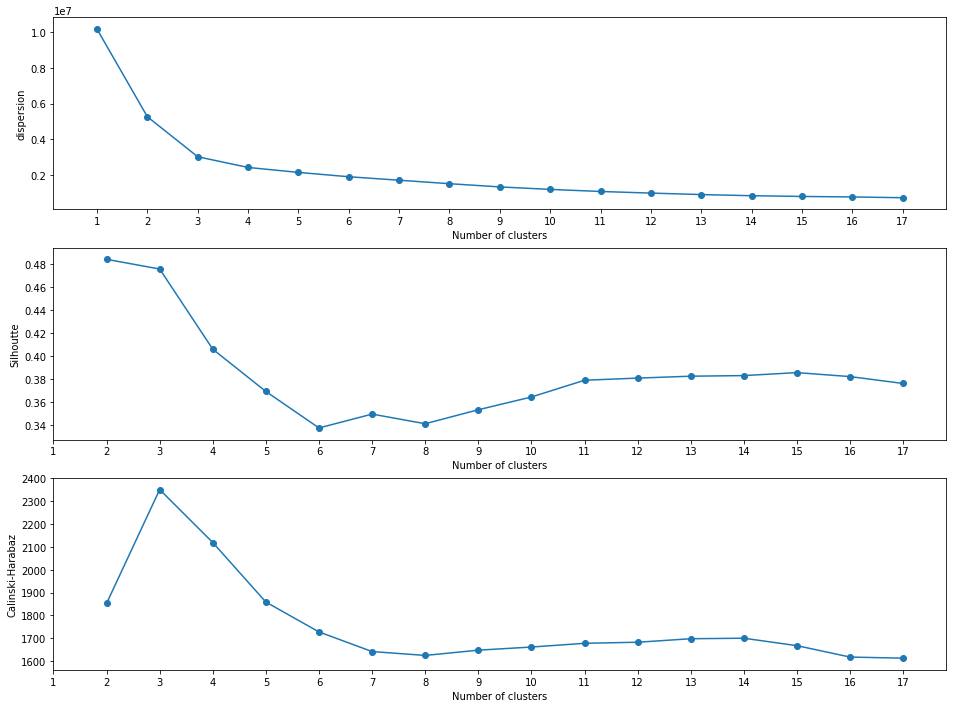

In [4]:
def score_k_means(X, sizes, scores, max_iter):
    single_out_score = set(scores) - set(["Gap", "Silhoutte", "Calinski-Harabaz"])
    if len(single_out_score) != 0:
        raise NotImplementedError(f"Not supported score: {single_out_score}")
    new_scores = ["dispersion", *scores]
    dict_scores = {score: np.zeros(len(sizes)) for score in new_scores}
    
    for id_size, size in enumerate(sizes):
        km = KMeans(n_clusters = size, max_iter = max_iter)
        km.fit(X)
        km_labels = km.predict(X)
        dict_scores["dispersion"][id_size] = km.inertia_
        for score in scores:
            res_score = np.NaN
            if score == "Silhoutte" and size > 1:
                res_score = sklearn.metrics.silhouette_score(X, km_labels)
            elif score == "Calinski-Harabaz" and size > 1:
                res_score = sklearn.metrics.calinski_harabaz_score(X, km_labels)
            elif score == "Gap":
                n_refs_expec = 3
                dispersions = np.zeros(n_refs_expec)
                mins = np.amin(X, axis = 0)
                maxs = np.amax(X, axis = 0)
                sum_min = np.kron(np.ones((X.shape[0], 1)), mins)
                ranges = maxs - mins
                mult_rang = np.kron(np.ones((X.shape[0], 1)), ranges)                
                for it in range(n_refs_expec):  
                    randoms= np.random.random_sample(X.shape)
                    reference_feature = mult_rang*randoms + sum_min
                    km_ref = KMeans(n_clusters = size, max_iter = max_iter)
                    km_ref.fit(reference_feature)
                    dispersions[it] = km_ref.inertia_
                res_score = np.log(dispersions).mean() - np.log(km.inertia_)
            dict_scores[score][id_size] = res_score
    return dict_scores

def plot_score_k_means(X, size_min, size_max, step = 1, scores = ["Silhoutte"], display_dispersion = False,
                      max_iter = 300):
    assert size_min > 0, "Number of clusters must be greater than 1"
    assert size_max > size_min, "size_max must be greater than size_min"
    sizes = range(size_min, size_max, step)
    dict_scores =  score_k_means(X, sizes, scores, max_iter)
    
    n_scores = len(scores)
    if display_dispersion:
        n_scores += 1
        plot_scores = ["dispersion", *scores]
    else:
        plot_scores = scores
        
    fig, axs = plt.subplots(n_scores, 1, figsize = (16, 4*n_scores))
    if n_scores == 1:
        axs = [axs]
    
    for ax, score in zip(axs, plot_scores):
        ax.plot(sizes, dict_scores[score])
        ax.scatter(sizes, dict_scores[score])
        ax.set_ylabel(score)
        ax.set_xlabel("Number of clusters")
        ax.set_xticks(sizes)

scores = ["Silhoutte", "Calinski-Harabaz"]
plot_score_k_means(X_dengue, 1, 18, scores = scores, step = 1, display_dispersion = True)

Observando las medidas de *Silhoutte* y *Calinski-Harabaz*, que se exponen en el artículo Tibshiriani et. al.(2001) como alternativas para la *Gap-statistic* enunciada en el libro de Elements of Statistical Learning que dan cuenta de que tan definidos están los clusters, en adición a la elbow strategy, se escoge el número óptimo de clusters como **n=3**.

## 23 b)

In [5]:
def scree_plot(prop_var_explained):
    fig, axs = plt.subplots(1, 2, figsize = (16, 6))
    ax1 = axs[0]
    ax1.plot(range(1, len(prop_var_explained) + 1), prop_var_explained, 'b-o')
    ax1.set_ylabel("Prop. Variance Explained")
    ax1.set_xlabel("Principal Component")
    ax1.set_ylim(0, None)
    
    cum_prop_variance = np.cumsum(prop_var_explained)
    ax2 = axs[1]
    ax2.plot(range(1, len(prop_var_explained) + 1), cum_prop_variance, 'b-o')
    ax2.set_ylabel("Cumulative Prop. Variance Explained")
    ax2.set_xlabel("Principal Component")
    ax2.set_ylim(0, None)

In [6]:
data_bake_df = pd.read_csv("BreadBasket_DMS.csv").dropna()
date_to_second = lambda x: time.mktime(time.strptime(x, "%Y-%m-%d"))
data_bake_df['Date'] = data_bake_df['Date'].apply(date_to_second)
time_to_second = lambda x: time.mktime(time.strptime(x, "%H:%M:%S")) - time.mktime(time.strptime("00:00:00", "%H:%M:%S"))
data_bake_df['Time'] = data_bake_df['Time'].apply(time_to_second)
uniques = set(data_bake_df['Item'])
dict_items = {k:v for v,k in enumerate(uniques)}
data_bake_df = data_bake_df.replace(dict_items)
data_bake = data_bake_df.values.astype(float)
scaler = StandardScaler()
scaler.fit(data_bake)
data_bake_scld = scaler.transform(data_bake)

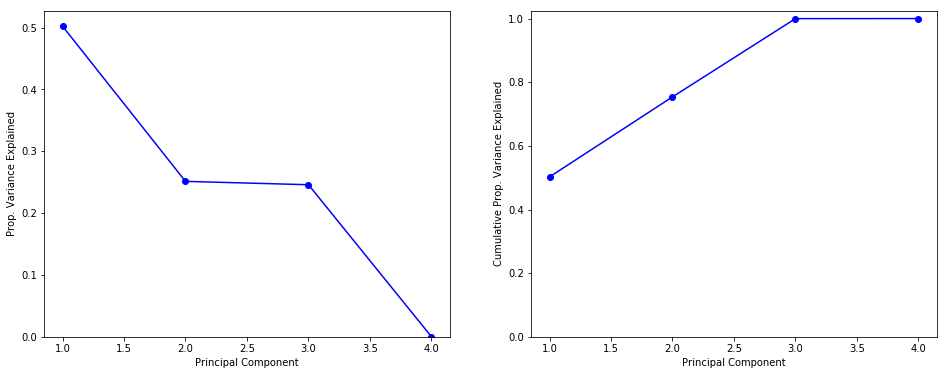

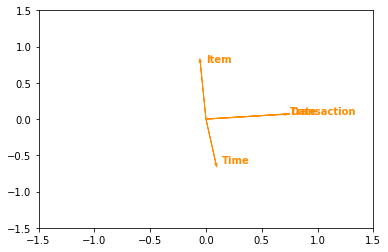

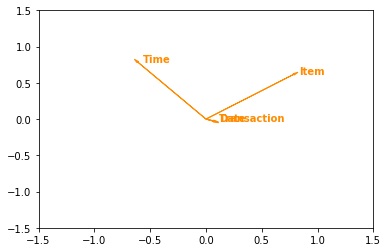

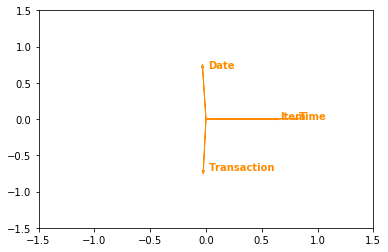

In [7]:
pca_full = PCA()
pca_full.fit(data_bake_scld)
scree_plot(pca_full.explained_variance_ratio_)


for i in range(3):
    fig = plt.figure()
    ax = plt.gca()
    loadings = pca_full.components_
    feature_keys = data_bake_df.columns
    for id_feature in range(len(feature_keys)):
        [x, y] = [loadings[id_pc, id_feature] for id_pc in range(i, i+2)]
        ax.arrow(0, 0, x, y, head_width=0.02, head_length=0.05, fc='darkorange', ec='darkorange')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.text(x + 0.05,  y, feature_keys[id_feature], color = "darkorange", fontweight = 'bold') 
        
    
    

Observando el PCA se observan, para las primeras dos dimensiones, que existe una alta correlación entre date y transaction. Esto confirma el hecho de que items comprados para una misma transacción en general se compran en el mismo día.

Se observa por otro lado que Time e Item tienen correlación, dado que los vectores asociados se superponen, grosso modo, en la misma dirección.

En tanto se obviara el feature de *Transaction* y se realizará análisis de *Date* vs *Item* y *Time* vs *Item*

In [8]:
bake_date_item = data_bake_df[["Item", "Date", "Time"]].values

Text(0, 0.5, 'Date')

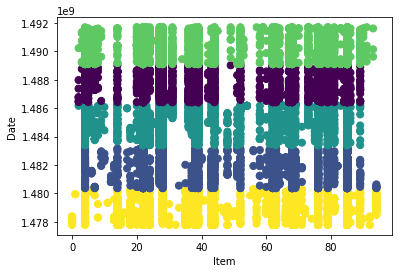

In [9]:
kmeans_bake = KMeans(n_clusters = 5) # Se escogen 5 de manera arbitraria. Evaluar el óptimo
                                     # con las medidas escogidas estaba tomando mucho
                                     # tiempo en binder
kmeans_bake.fit(bake_date_item)
y_kmeans = kmeans_bake.predict(bake_date_item)

plt.scatter(bake_date_item[:, 0], bake_date_item[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.xlabel("Item")
plt.ylabel("Date")# Problema, clusters están terminando triviales.

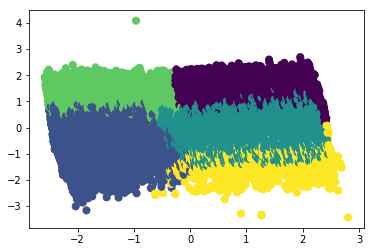

In [10]:
pca_3 = PCA(n_components = 3)
pca_3.fit(data_bake_scld)
data_bake_3 = pca_3.transform(data_bake_scld)
kmeans_bake = KMeans(n_clusters = 5)
kmeans_bake.fit(data_bake_3)
y_kmeans = kmeans_bake.predict(data_bake_3)

plt.scatter(data_bake_3[:, 0], data_bake_3[:, 1], c=y_kmeans, s=50, cmap='viridis')

Falta realizar la asociación entre la identidad de los clusters y tiempos, items y fechas con el fin de encontrar las tendencias.